# Web Scraping for Indeed.com and Predicting Salaries

### Goal

Determine the industry factors that are most important in predicting the salary amounts for data-related jobs (e.g. data scientist, data analyst, research scientist, business intelligence) in the UK.

I will scrape job-related data from the [Indeed.co.uk](https://www.indeed.co.uk).

---

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, I split the salary into two groups of high and low salary.

### Scraping job listings from Indeed.co.uk

I will be scraping job listings from Indeed.co.uk using BeautifulSoup. 

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the Indeed. Use BeautifulSoup to parse the page and extract all results

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [ ]:
URL = "http://www.indeed.co.uk/jobs?q=data+scientist+%2420%2C000&l=London&start=1"

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import pandas_profiling as pp
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
r_ = requests.get(URL)
soup = BeautifulSoup(r_.text, 'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

In [ ]:
# extract job titles from html passed as a parameter
def extract_job(r):
    job = ''
    
    try:
        job = r.find('a', attrs={'class': 'jobtitle turnstileLink', 'data-tn-element':'jobTitle'}).text
    except:
        job = np.nan
        
        
    return job

In [ ]:
def extract_company(r):
    company = ''
    
    try:
        company = r.find('span', attrs={'class': 'company'}).text
    except:
        company = np.nan
       
    
    return company

In [ ]:
# Append the city searched for to the location scraped. This will make it to group jobs together based on common locatiions.
def extract_location(r, city):
    location = ''
    
    try:
        location = r.find('span', attrs={'class':'location accessible-contrast-color-location'}).text
        location = location + ', ' + city
    except:
        location = np.nan
            
            
    return location

In [ ]:
extract_location(soup, 'London')

In [ ]:
def extract_salary(r):
    salary = ''
    
    try:
        salary = r.find('span', attrs={'class': 'salaryText'}).text
    except:
        salary = np.nan
            
            
    return salary

In [ ]:
extract_salary(soup)

### Scrape all required from Indeed.co.uk

Requirements
- Data-related jobs in the UK

In [ ]:
YOUR_CITY = 'London'

In [ ]:
# define the url, max results, cities and jobs to search for
url = "https://www.indeed.co.uk/jobs?q={}+%C2%A320%2C000&l={}&start={}"
max_results_per_city = 301

# define cities to include
cities = [YOUR_CITY, 'Manchester', 'Liverpool', 'Edinburgh', 'Cardiff', 'Belfast', 'Southampton',
           'Cambridge', 'Oxford', 'Bath', 'Bristol', 'Exeter', 'Leeds', 'Birmingham', 'Glasgow', 'Sheffield']

# define job titles to search for
jobs = ['data+scientist', 'data+analyst', 'bi+analyst', 'business+intelligence', 'analytics', 'machine+learning']

results = []

# iterate through search results for each city and job combination
for city in tqdm(cities):
    for job in jobs:
        for start in range(0, max_results_per_city, 10):
            r_ = requests.get(url.format(job, city, start))
            bs = BeautifulSoup(r_.text, 'html.parser')
            results.append(bs)

In [ ]:
len(results)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [ ]:
#prepare data frame for storing results
job_results = pd.DataFrame(columns=['job', 'company', 'location', 'salary'])

# loop through each job scraped previously and extract relevant details.
for result in tqdm(results):
    
        city_searched = result.find('h1', attrs={'id': 'jobsInLocation'}).text.split()[-1]
        
        for listing in result.find_all('div', attrs={'data-tn-component':'organicJob'}):
        
            job_data = {'job': extract_job(listing),
                        'company': extract_company(listing),
                        'location': extract_location(listing, city_searched),
                        'salary': extract_salary(listing)}
        
            job_results = job_results.append(job_data, ignore_index=True)


In [ ]:
job_results.shape

In [ ]:
job_results.head()

In [ ]:
job_results.isnull().sum()

In [ ]:
job_results.dtypes

Scraping seems to have worked well. There is an obvious issue with missing salary details which I will deal with later. The thing to tackle next is to improve the quality of the data stored in each feature.

---

### Remove un-necessary characters from feature values

Specifically, remove:
- `\n` characters
- remove whitespace

In [ ]:
# function will remove any newline or whitespace, plus convert empty values to NAN
def remove_formatting(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: str(x).replace('\n', '').strip() if not pd.isnull(x) else np.nan)

In [ ]:
# call function with job_results data frame
remove_formatting(job_results)

In [ ]:
job_results.head(10)

The data nows looks to be in a better format, the next step is to sort out the location values.

---

### Improve location values

Specifically, define locations based on the city searched for. If I don't do this I will end up with a feature with high cardinality which I don't really want as I may end up with a very long list of locations which relate to very few jobs. This will make it harder for me to understand how location relates to salary.

In [ ]:
# number of unique locations scraped!
job_results.location.nunique()

In [ ]:
# location data looks really mixed, postcode, boroughs, cities, towns, counties, ... 
# Adding the location search term will make it much easier to make sense of this.
job_results.location.unique()

In [ ]:
# function to split location data into a list and return the city location relates to
def set_location(s):
    return ''.join([city for city in cities if city in s.split()][0])

In [ ]:
job_results['location'] = job_results.location.apply(set_location)

In [ ]:
job_results.head()

In [ ]:
# locations now related to the citites searched for
job_results.location.nunique()

In [ ]:
# job data fairly evenly distrubted between locations
job_results.location.value_counts(dropna=False)

In [ ]:
job_results.shape

---

### Remove duplicates from data frame

Duplicates are defined as those rows which have the same values for all features.

In [ ]:
job_results.drop_duplicates(keep='first', inplace=True)

In [ ]:
job_results.shape

---

### Filter jobs

Looking at the jobs returned by the scraping, it appears a significant proportion relate to jobs not linked to my search terms (or data science). Therefore, I need to filter my results to ensure only relevant jobs are included.

In [ ]:
# define list of keywords data jobs will potentially include
keywords = ['data ','bi ','analytics','business intelligence','ai','ml ','machine learning',
           'deep learning','nlp','insights','artificial intelligence','scientist','natural language processing',
           'sql', 'etl ']

In [ ]:
filtered_jobs = job_results.copy()

In [ ]:
# Only keep jobs that include one of the keywords in their title
filtered_jobs = filtered_jobs[[any([k in job.lower() for k in keywords]) for job in filtered_jobs.job]].copy()

In [ ]:
# exclude jobs based on certain terms
filtered_jobs = filtered_jobs[['paid' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['ppc' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['phd studentship' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['de&s air engineering' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['lecturer' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['dio overseas' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['recruitment consultant' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['postdoctoral' not in job.lower() for job in filtered_jobs.job]]
filtered_jobs = filtered_jobs[['professor' not in job.lower() for job in filtered_jobs.job]]

In [ ]:
# exclude certain job titles
excluded_jobs = ['Marine Claims Examiner', 'Communications data investigator',
'Email Marketing Specialist - Spiceworks','Analytics Liaison Support (UK)','In Team Trainer- FDX',
'Solution Sales Specialist - Acorn AI','Data Governance & Quality Lead','Payroll and Training Officer', 
'Claims Actuary', 'Tekla Detailer', 'Test Issues Analyst (SQL / DEFECT MANAGEMENT/ MS OFFICE)',
 'Taiwan eCommerce Executive - THG Ingenuity', 'Commercial Finance Business Partner - Warrington - Retail-',
 'Senior Manager, Clinical Affairs EMEA', 'Medical Science Liaison','AML & Sanctions Governance Officer',
 'Analytics Support - NHS','ACCA Trainee – Financial Services Audit - Manchester',
'Digital Manager (located in Kyiv, Ukraine)','IT Project Manager (Data Strategy)',
'Airborne Mission Systems - Software Engineer Sr','CRM Email Developer','Supply Chain Analyst',
'L2/HEO Trainee Examiner OR Cambridge and Ipswich', 'Supply Chain Analyst', 'Maintenance Team Leader',
'Maintenance Engineer', 'Maintenance Person -The Grange Care Home', 'Buyer / Category Manager – Online Retail'
'Lecturer in AI Hardware/ Associate Professor in AI Hardware', 'Retail Field Sales Executive',
 'Management Development Trainer', 'Data Migration Developer', 'People Insights and Workforce Planning Lead',
'Email Marketing Manager','Head of UK Retail Marketing',
 'Data Integration Specialist Edinburgh',
 'Data Integration Specialist','Email Marketing Specialist','Supply Chain Manager','Head of Security - Air UK',
'Communications/Campaign Manager - Government Covid19 (CM/54)','Supply Chain Manager','Finance Graduate - Data & FP&A',
'Head of Campaigns / Head of Marketing','Chairperson of UK Bank','Major Account Director - BI Sales','Claims & Performance Analyst (Insurance)',
'Internal Quality Assurer (IQA) Data Analysts L4', 'Program Manager: CRM Data Integration in EpiCX Program',
'Maintenance Technician', 'Clinical Vascular Scientist','Route Training Support Manager','Sales Business Analytics Manager',
'Earth Observation Scientists','Games / UX Designer for AI Platform', 'Engineering Apprentice Trainer',
 'React Native/Web Front End Developer for AI Platform','Postdoctoral Research Scientist',
'Junior Broker - Full Training Provided','Big Data Software Sales - PRE IPO','Buyer / Category Manager – Online Retail']

In [ ]:
filtered_jobs = filtered_jobs[[all([e not in j for e in excluded_jobs]) for j in filtered_jobs.job]]

In [ ]:
filtered_jobs.shape

In [ ]:
list(filtered_jobs.job)

---

### Exclude jobs that do not have salary data.

A significant number of jobs do not include salary data. It is impossible to know what their values should be so they will be dropped from the data frame.

In [ ]:
filtered_jobs.isnull().sum()

In [ ]:
filtered_jobs.dropna(inplace=True)

In [ ]:
filtered_jobs.isnull().sum()

In [ ]:
filtered_jobs.shape

---

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [ ]:
# terms to search for which we want to exclude
pay_range_filter = ['hour', 'day', 'week']

In [ ]:
# exclude jobs whose salary data includes any of the filter terms above.
filtered_jobs = filtered_jobs[[all([k not in sal.lower() 
                                    for k in pay_range_filter]) 
                               for sal in filtered_jobs.salary]].copy()

In [ ]:
# only left with jobs that have yearly salary data
filtered_jobs.salary.unique()

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [ ]:
# extract digits from a salary and convert to an integer
# divide the sum of the salary data by the number of salary values found.
def convert_salary(sal):
    sal_range = re.findall(r'\d{1,},\d{1,}', sal)
    
    sal_range = list(map(lambda x: int(x.replace(',', '')), sal_range))
    
    return sum(sal_range) / len(sal_range)

In [ ]:
filtered_jobs['salary'] = filtered_jobs.salary.apply(convert_salary)

In [ ]:
filtered_jobs.info()

In [ ]:
filtered_jobs.head()

### Save your results as a CSV

In [ ]:
filtered_jobs.to_csv('data_science_jobs.csv', index=False)

### Load in the the data of scraped salaries

In [26]:
ds_jobs = pd.read_csv('data_science_jobs.csv')

In [27]:
ds_jobs.head()

,job,company,location,salary
0,Data Scientist,Public Health England,London,42567.0
1,Graduate Data Scientist,UK Government - Office for National Statistics,London,29540.0
2,Data Scientist – Team Lead,SoulTek,London,85000.0
3,919-SA-33705099-EXT Data Scientist,Public Health England,London,42567.0
4,Technical Analyst / Data Scientist,Policy in Practice,London,37500.0


### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [28]:
# see how the salary values are distributed.
ds_jobs.describe().T

,count,mean,std,min,25%,50%,75%,max
salary,526.0,50757.25,21384.498871,20000.0,35907.0,47097.75,60000.0,175000.0


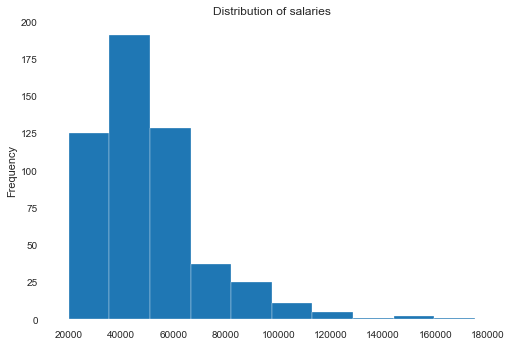

In [29]:
ds_jobs.salary.plot.hist(bins=10, title='Distribution of salaries');

In [30]:
# High salary defined as anything >= 75% percentile, Low is everything else
ds_jobs['salary_cat'] = ds_jobs.salary.apply(lambda x : 1 if x >= 60000 else 0)

In [31]:
ds_jobs.head(10)

,job,company,location,salary,salary_cat
0,Data Scientist,Public Health England,London,42567.0,0
1,Graduate Data Scientist,UK Government - Office for National Statistics,London,29540.0,0
2,Data Scientist – Team Lead,SoulTek,London,85000.0,1
3,919-SA-33705099-EXT Data Scientist,Public Health England,London,42567.0,0
4,Technical Analyst / Data Scientist,Policy in Practice,London,37500.0,0
5,Data Scientist,Bank of England,London,47950.0,0
6,Data Scientist,MBN Solutions,London,60000.0,1
7,Data Scientist,Ampersand Consulting,London,65000.0,1
8,Data Scientist - Head of Business Intelligence,UK Government - Marine Management Organisation,London,55029.0,0
9,Insights Data Scientist,SoulTek,London,52500.0,0


#### Thought experiment: What is the baseline accuracy for this model?

In [32]:
# Baseline accuracy
ds_jobs.salary_cat.value_counts(normalize=True).max()

0.7186311787072244

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

### Create new features based on keywords

Create features based on indicators of seniority...

In [33]:
# job seniority
seniority = ['intern', 'graduate', 'senior', 'head', 'manager', 'chief', 
              'lead', 'director', 'principal', 'officer']

In [34]:
for s in seniority:
    ds_jobs[s] = ds_jobs.job.apply(lambda x : 1 if s in x.lower() else 0)

In [35]:
ds_jobs.shape

(526, 15)

In [36]:
job_type = {'ml': ['ml', 'machine learning', 'ai', 'artifical itelligence', 'nlp', 'deep learning'],
  'science': ['science', 'scientist'], 
  'research': ['research', 'researcher', 'fellow'], 
  'engineer': ['engineer', 'developer'], 
  'bi': ['bi', 'business intelligence'],
  'consultant': ['consultant'],
  'analyst': ['analyst']}

In [37]:
for jt in job_type.items():
    ds_jobs[jt[0]] = ds_jobs.job.apply(lambda x: 1 if any([t in x.lower() for t in jt[1]]) else 0)

In [38]:
ds_jobs.shape

(526, 22)

In [39]:
ds_jobs.iloc[:, 4:].sum(axis=0)

salary_cat    148
intern          2
graduate        6
senior         68
head           11
manager        34
chief           3
lead           26
director        3
principal       6
officer         6
ml             91
science       123
research       33
engineer      147
bi            131
consultant     11
analyst       161
dtype: int64

---

## Model 1: Logisitic Regression (location only)

In [40]:
X = ds_jobs.location
X = pd.get_dummies(X, columns=['location'], drop_first=True)
y = ds_jobs.salary_cat

In [41]:
X.head()

,Belfast,Birmingham,Bristol,Cambridge,Cardiff,Edinburgh,Exeter,Glasgow,Leeds,Liverpool,London,Manchester,Oxford,Sheffield,Southampton
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [42]:
X.shape, y.shape

((526, 15), (526,))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=4)

In [78]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((368, 32), (158, 32), (368,), (158,))

In [45]:
model = LogisticRegression(solver='liblinear')

params = {'C': np.logspace(-3, 3, 500),
         'penalty': ['l1', 'l2']}

gs = GridSearchCV(model, params, scoring='accuracy', verbose=1, cv=5, n_jobs=2, return_train_score=True)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 174 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 2094 tasks      | elapsed:   18.4s
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:   37.3s finished


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=2,
             param_grid={'C': array([1.00000000e-03, 1.02807322e-03, 1.05693455e-03, 1.08660611e-03,
       1.11711065e-03, 1.14847155e-03, 1.18071285e-03, 1.21385926e-03,
       1.24793621e-03, 1.28296980e-03, 1.31898690e-03, 1.35601511e-03,
       1.39408283e-03, 1.43321923e-03, 1.47345431e-03, 1.51481892e-03,
       1.55734477e...
       5.90939590e+02, 6.07529169e+02, 6.24584471e+02, 6.42118571e+02,
       6.60144909e+02, 6.78677305e+02, 6.97729965e+02, 7.17317494e+02,
       7.37454909e+02, 7.58157646e+02, 7.79441575e+02, 8.01323013e+02,
       8.23818733e+02, 8.46945981e+02, 8.70722485e+02, 8.95166472e+02,
       9.20296681e+02, 9.46132376e+02, 9.72693362e+02, 1.00000000e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [46]:
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs.score(X_test, y_test))

Best Parameters:
{'C': 0.4066478091781858, 'penalty': 'l1'}
Best estimator C:
0.4066478091781858
Best estimator mean cross validated training score:
0.7380952380952381
Best estimator score on the full training set:
0.7380952380952381
Best estimator score on the test set:
0.7264150943396226


In [47]:
gs_best = gs.best_estimator_

In [48]:
# turn into a function to create coefficients
coef_df = pd.DataFrame({'feature': X.columns,
                        'coef': gs_best.coef_[0],
                        'abs_coef': np.abs(gs_best.coef_[0])})

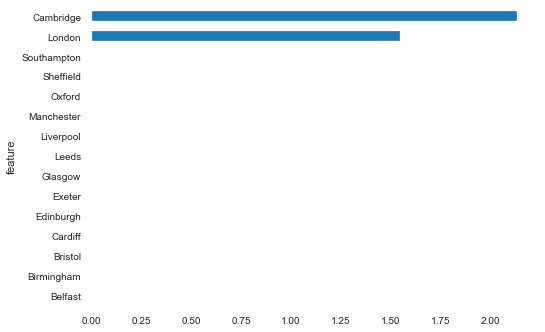

In [49]:
coef_df.sort_values(by='coef').plot(kind='barh', x='feature', y='coef', legend=False);

In [50]:
cross_val_score(gs.best_estimator_, X_train, y_train, cv=5).mean()

0.7380952380952381

In [51]:
predictions_train = gs.predict(X_train)
predictions_test = gs.predict(X_test)

In [52]:
gs.classes_

array([0, 1])

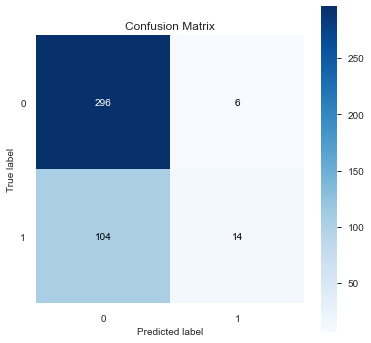

In [53]:
skplt.metrics.plot_confusion_matrix(y_train, predictions_train, labels=[0,1], figsize=(6, 6))
plt.show()

---

## Model(s) 2: LR, Ada, RF, Bag (location, seniority, type)

In [3]:
ds_jobs = pd.read_csv('data_science_jobs.csv')

# job seniority
seniority = ['intern', 'graduate', 'senior', 'head', 'manager', 'chief', 
              'lead', 'director', 'principal', 'officer']


job_type = {'ml': ['ml', 'machine learning', 'ai', 'artifical itelligence', 'nlp', 'deep learning'],
  'science': ['science', 'scientist'], 
  'research': ['research', 'researcher', 'fellow'], 
  'engineer': ['engineer', 'developer'], 
  'bi': ['bi', 'business intelligence'],
  'consultant': ['consultant'],
  'analyst': ['analyst']}

In [4]:
ds_jobs['salary_cat'] = ds_jobs.salary.apply(lambda x : 1 if x >= 60000 else 0)

In [5]:
X = ds_jobs.copy()
y = X.pop('salary_cat')

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class JobPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, dummy_cols, job_levels, job_types):
        
        self.cols_to_drop = cols_to_drop
        self.dummy_cols = dummy_cols
        self.job_levels = job_levels
        self.job_types = job_types
        
        
    def _drop_cols(self, X):
        X.drop(self.cols_to_drop, axis=1, inplace=True)
        return X
    
    
    def _dummify_cols(self, X):
        return pd.get_dummies(X, columns=self.dummy_cols, drop_first=True)
    
    
    def _create_seniority_cols(self, X):
        
        df = X.copy()
        
        for s in self.job_levels:
            df[s] = df.job.apply(lambda a : 1 if s in a.lower() else 0)
            
        return df
    
    
    def _create_type_cols(self, X):
        
        df = X.copy()
        
        for jt in self.job_types.items():
            df[jt[0]] = df.job.apply(lambda a: 1 if any([t in a.lower() for t in jt[1]]) else 0)

        return df
    
    
    def transform(self, X, *args):
        
        X = self._create_seniority_cols(X)
        X = self._create_type_cols(X)
        X = self._dummify_cols(X)
        X = self._drop_cols(X)

        return X
        
    
    def fit(self, X, *args):
        return self
        

In [7]:
cols_to_drop = ['job', 'company', 'salary'] 
cols_to_dummify = ['location']
cities = list(X.location.unique())

features = JobPreprocessor(cols_to_dummify, seniority, job_type) # seniority & job_type from above

In [8]:
X = features.fit_transform(X)

In [9]:
X.shape, y.shape

((526, 32), (526,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=4)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((368, 32), (158, 32), (368,), (158,))

---

#### Logistic Regression

In [207]:
lr_params = {'C': np.logspace(-3, 3, 100),
             'penalty': ['l1', 'l2']}

lr_model = LogisticRegression(solver='liblinear')

gs = GridSearchCV(lr_model, lr_params, verbose=1, cv=5, scoring='accuracy', n_jobs=2, return_train_score=True)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 540 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    5.2s finished


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=2,
             param_grid={'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [208]:
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs.score(X_test, y_test))

Best Parameters:
{'C': 0.4641588833612782, 'penalty': 'l1'}
Best estimator C:
0.4641588833612782
Best estimator mean cross validated training score:
0.8177341725286931
Best estimator score on the full training set:
0.8233695652173914
Best estimator score on the test set:
0.7974683544303798


In [209]:
lr_model = gs.best_estimator_

# turn into a function to create coefficients
coef_df = pd.DataFrame({'feature': X.columns,
                        'coef': lr_model.coef_[0],
                        'abs_coef': np.abs(lr_model.coef_[0])})

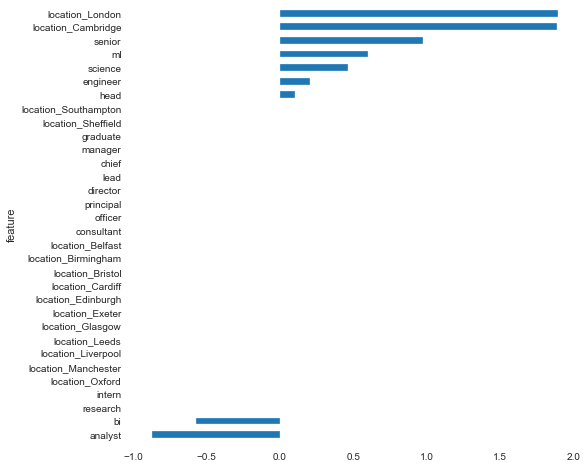

In [210]:
coef_df.sort_values(by='coef').plot(kind='barh', x='feature', y='coef', legend=False, figsize=(8, 8));

In [211]:
predictions_lr = lr_model.predict(X_train)

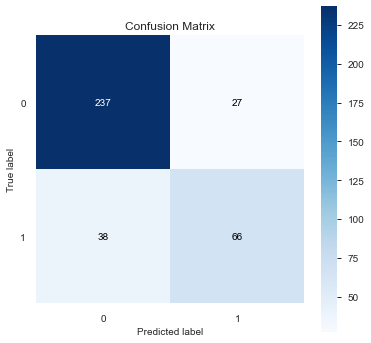

In [212]:
skplt.metrics.plot_confusion_matrix(y_train, predictions_lr, labels=[0,1], figsize=(6, 6))
plt.show()

In [213]:
print(classification_report(y_train, predictions_lr, labels=lr_model.classes_))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       264
           1       0.71      0.63      0.67       104

    accuracy                           0.82       368
   macro avg       0.79      0.77      0.77       368
weighted avg       0.82      0.82      0.82       368



Logisitic regression produces a fairly consistent model, with CV, Train and Test scores all being very close to each other.

The strongest predictors for High salaries were locations London and Cambridge, as well as jobs with senior, ml and science in the title. The strongest predictors for Low salaries were the words 'analyst' and 'bi' appearing in the title. These results don't suprise me as those predictors which enhance a prediction being part of the High salary class make intuituve sense. The keywords ('bi, 'analyst') which diminish the chance of being in the High salary class, and enhance the chance of being Low salary, were note so obvious but do make sense. Specifically, business intelligence and analyst roles could be thought of as being more junior roles than others included as predictors, so it would make sense that lower salary jobs relate to those descriptions.

Finally, the confusion amd classification reports show that that model is not as good as predicting high salary jobs as low salary jobs. In particular it classified only 63% of high-paying jobs correctly (recall for class 1), whereas 90% of low salary jobs were classified correctly (recall score for 0).

In [214]:
X_train_copy = X_train.copy()

In [215]:
X_train_copy['salary_cat'] = y_train

In [216]:
X_train_copy.corr().iloc[32].sort_values(ascending=False)

salary_cat              1.000000
location_London         0.351543
science                 0.264810
location_Cambridge      0.222228
ml                      0.178512
head                    0.154928
senior                  0.140719
lead                    0.114785
chief                   0.083167
consultant              0.050612
manager                 0.046403
engineer                0.031462
research                0.001979
location_Edinburgh      0.000960
location_Belfast       -0.007592
location_Glasgow       -0.021532
intern                 -0.032763
director               -0.032763
graduate               -0.033151
location_Exeter        -0.046397
principal              -0.046397
location_Cardiff       -0.065795
location_Sheffield     -0.065795
officer                -0.073662
location_Oxford        -0.092456
location_Southampton   -0.099378
location_Bristol       -0.107355
location_Liverpool     -0.110173
location_Manchester    -0.121482
location_Birmingham    -0.132811
location_L

---

#### Random Forest

In [217]:
from sklearn.ensemble import RandomForestClassifier

In [218]:
rfc = RandomForestClassifier(n_jobs=2, random_state=1)

params = {'n_estimators': np.linspace(70, 200, 30).astype(int),
          'max_depth': [3, 7, 9, 11], 
          'min_samples_leaf': [ 5, 7, 10],
          'bootstrap': [False, True]}

gs_rfc = GridSearchCV(rfc, params, verbose=1, cv=5, n_jobs=2,
                     return_train_score=True, scoring='accuracy')

gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   43.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 11.6min
[Parallel(n_jobs=2)]: Done 3600 out of 3600 | elapsed: 13.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=2, random_state=1),
             n_jobs=2,
             param_grid={'bootstrap': [False, True], 'max_depth': [3, 7, 9, 11],
                         'min_samples_leaf': [5, 7, 10],
                         'n_estimators': array([ 70,  74,  78,  83,  87,  92,  96, 101, 105, 110, 114, 119, 123,
       128, 132, 137, 141, 146, 150, 155, 159, 164, 168, 173, 177, 182,
       186, 191, 195, 200])},
             return_train_score=True, scoring='accuracy', verbose=1)

In [219]:
print('Best Parameters:')
print(gs_rfc.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_rfc.best_score_)
print('Best estimator score on the full training set:')
print(gs_rfc.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_rfc.score(X_test, y_test))

Best Parameters:
{'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 191}
Best estimator mean cross validated training score:
0.7826730840429471
Best estimator score on the full training set:
0.8260869565217391
Best estimator score on the test set:
0.7911392405063291


In [220]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gs_rfc.best_estimator_.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
27,location_London,0.303989
11,science,0.130526
20,location_Cambridge,0.118703
16,analyst,0.106975
14,bi,0.077222
10,ml,0.068663
2,senior,0.053077
3,head,0.022904
25,location_Leeds,0.019397
13,engineer,0.019198


In [221]:
rfc_predict = gs_rfc.predict(X_train)

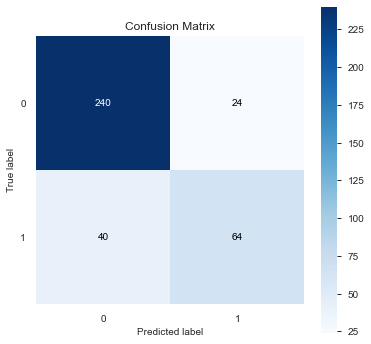

In [222]:
skplt.metrics.plot_confusion_matrix(y_train, rfc_predict, labels=[0,1], figsize=(6, 6))
plt.show()

In [223]:
print(classification_report(y_train, rfc_predict, labels=gs_rfc.classes_))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       264
           1       0.73      0.62      0.67       104

    accuracy                           0.83       368
   macro avg       0.79      0.76      0.77       368
weighted avg       0.82      0.83      0.82       368



The results achieved with a random forest were similar to logisitic regression. It is pleasing to see the the accuracy results were consistent across the CV, train and test scores. I don't think the optimal model chosen is that suprising. It liked having a signficant number of trees in the forest, it preferred to have the min number of samples as possibles for the leaf nodes which would impact on the max depth score as a result. Finally, it preferred to not replace samples when choosing data to use. The feature importance scores also seem to make sense as they are the features that have the largest correlations with salary (and match the coefficients from logisitic regression)

The confusion and classification reports tell a similar story to logisitic regression. The Precision score for class 1 (high salary) improved slightly when compared to logisitic regression. This is due to less low salary jobs being classifed as high salary.  However, the Recall score for high salary decreased due to more high salary jobs being classified as low salary.

---

#### AdaBoost

In [224]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier

In [225]:
ada_tree = DecisionTreeClassifier(max_depth=1, random_state=1)
ada = AdaBoostClassifier(base_estimator=ada_tree, random_state=1)

ada_params = {'n_estimators': np.linspace(500, 2000, 10).astype(int), 
         'learning_rate': [0.005, 0.01, 0.05]}

gs_ada = GridSearchCV(ada, ada_params, verbose=1, cv=5, n_jobs=2,
                     return_train_score=True, scoring='accuracy')

gs_ada.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   44.8s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  2.5min finished


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                random_state=1),
                                          random_state=1),
             n_jobs=2,
             param_grid={'learning_rate': [0.005, 0.01, 0.05],
                         'n_estimators': array([ 500,  666,  833, 1000, 1166, 1333, 1500, 1666, 1833, 2000])},
             return_train_score=True, scoring='accuracy', verbose=1)

In [226]:
print('Best Parameters:')
print(gs_ada.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_ada.best_score_)
print('Best estimator score on the full training set:')
print(gs_ada.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_ada.score(X_test, y_test))

Best Parameters:
{'learning_rate': 0.01, 'n_estimators': 1166}
Best estimator mean cross validated training score:
0.8014439096630877
Best estimator score on the full training set:
0.8233695652173914
Best estimator score on the test set:
0.7911392405063291


In [227]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gs_ada.best_estimator_.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
27,location_London,0.239280
20,location_Cambridge,0.155232
2,senior,0.126930
16,analyst,0.115780
10,ml,0.083190
14,bi,0.062607
3,head,0.058319
11,science,0.048885
12,research,0.030875
13,engineer,0.028302


In [228]:
ada_predict = gs_ada.predict(X_train)

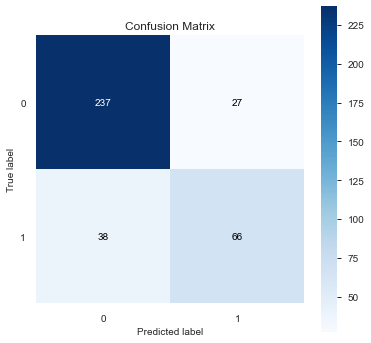

In [229]:
skplt.metrics.plot_confusion_matrix(y_train, ada_predict, labels=[0,1], figsize=(6, 6))
plt.show()

In [230]:
print(classification_report(y_train, ada_predict, labels=gs_ada.classes_))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       264
           1       0.71      0.63      0.67       104

    accuracy                           0.82       368
   macro avg       0.79      0.77      0.77       368
weighted avg       0.82      0.82      0.82       368



The optimal model for AdaBoost isn't that suprising. A lower learning rate means the model will learn more slowly, and having more esimators means we have more weak learners to learn from. I would expected the learning rate and estimator to be inversely proportional (upto a certain point). Specifically, if we are learning at a slower pace then we need more models (learners) to create the optimal final model. In terms of the features importances', AdaBoost rated London, Cambridge and Senior features as the most important.


The confusion and classification reports show similar results to the previous models. Specifically, more low salary jobs are being classified as high salary, leading to a lower precision score for class 1 (high salary). However, less high salary jobs are being classified as low salary, resulting in a better recall score for class 1.

---

#### Bagging

In [231]:
bag_tree = DecisionTreeClassifier(max_depth=9, random_state=1, min_samples_leaf=5)
bag = BaggingClassifier(base_estimator=bag_tree, random_state=1)

bag_params = {'n_estimators': np.linspace(150, 500, 30).astype(int),
              'bootstrap': [False, True],
              'bootstrap_features': [False, True]}


gs_bag = GridSearchCV(bag, bag_params, verbose=1, cv=5, n_jobs=2,
                     return_train_score=True, scoring='accuracy')

gs_bag.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   55.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:  3.0min finished


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=9,
                                                                               min_samples_leaf=5,
                                                                               random_state=1),
                                         random_state=1),
             n_jobs=2,
             param_grid={'bootstrap': [False, True],
                         'bootstrap_features': [False, True],
                         'n_estimators': array([150, 162, 174, 186, 198, 210, 222, 234, 246, 258, 270, 282, 294,
       306, 318, 331, 343, 355, 367, 379, 391, 403, 415, 427, 439, 451,
       463, 475, 487, 500])},
             return_train_score=True, scoring='accuracy', verbose=1)

In [232]:
print('Best Parameters:')
print(gs_bag.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_bag.best_score_)
print('Best estimator score on the full training set:')
print(gs_bag.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_bag.score(X_test, y_test))

Best Parameters:
{'bootstrap': True, 'bootstrap_features': False, 'n_estimators': 270}
Best estimator mean cross validated training score:
0.8096630877452796
Best estimator score on the full training set:
0.8206521739130435
Best estimator score on the test set:
0.8037974683544303


In [233]:
# create feature importances using the average feature importance from all estimators in the best estimator
feature_importances = np.mean([
    tree.feature_importances_ for tree in gs_bag.best_estimator_.estimators_
], axis=0)

In [234]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
27,location_London,0.304404
20,location_Cambridge,0.211867
10,ml,0.102031
11,science,0.098335
16,analyst,0.077983
2,senior,0.069614
14,bi,0.053983
13,engineer,0.033824
6,lead,0.008122
12,research,0.007163


In [235]:
bag_predict = gs_bag.predict(X_train)

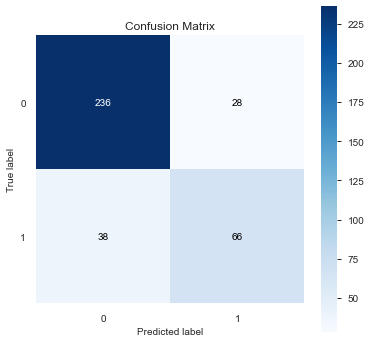

In [236]:
skplt.metrics.plot_confusion_matrix(y_train, bag_predict, labels = gs_bag.classes_, figsize=(6, 6));

In [237]:
print(classification_report(y_train, bag_predict, labels=gs_bag.classes_))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       264
           1       0.70      0.63      0.67       104

    accuracy                           0.82       368
   macro avg       0.78      0.76      0.77       368
weighted avg       0.82      0.82      0.82       368



No real suprise with the model choice. It liked have a reasonable number of estimators, and preferred to replace both samples and features when make selections for the estimator models. The accuracy scores were (again!) fairly consistent, and also matched those achieved by the previous models. In this case, the (average) feature importance scores were similar other models run. 


The confusion and classificaiton reports are almost idenditical to the other models run.

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

A preference for telling people incorrectly they would get a low salary job implies that we need to optimise a model to increase the Recall score for the low salary class. 

There are two ways that come to mind that we could fo this. First, we good alter our grid searches to optimise the scoring parameter based on achieving the best recall scores. Unfortunately, when I tried doing this for the models above, it did not result in an improvement in recall scores for class 0. Specifically, it had virtually no impact. This, then, leads us on to the second approach we can take, which is to adjust the threshold values for which jobs are classified as low or high salary. I will use the logistic regression model for this purpose.

In [372]:
# define LR model based on optimal parameters
lr_model = LogisticRegression(solver='liblinear', C=0.4641588833612782, penalty='l1')

lr_model.fit(X_train, y_train)

print("CV score: ", cross_val_score(lr_model, X_train, y_train, cv=5).mean())
print("Train score", lr_model.score(X_train, y_train))
print("Test score", lr_model.score(X_test, y_test))

CV score:  0.8177341725286931
Train score 0.8233695652173914
Test score 0.7974683544303798


In [373]:
lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)
lr_prob_train = lr_model.predict_proba(X_train)
lr_prob_test = lr_model.predict_proba(X_test)

In [374]:
print(classification_report(y_train, lr_pred_train, labels=lr_model.classes_))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       264
           1       0.71      0.63      0.67       104

    accuracy                           0.82       368
   macro avg       0.79      0.77      0.77       368
weighted avg       0.82      0.82      0.82       368



In [251]:
print(classification_report(y_test, lr_pred_test, labels=lr_model.classes_))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       114
           1       0.71      0.45      0.56        44

    accuracy                           0.80       158
   macro avg       0.76      0.69      0.71       158
weighted avg       0.79      0.80      0.78       158



Currently, our default Logistic Regression (LR) model is pretty good at predicting low salaries. This can be seen by the high scores for both precision and recall for class 0. It is not so good at predicting high salary, and in particular classifying actual high salary jobs accurately (as can be seen by the relatively low recall scores for class 1).

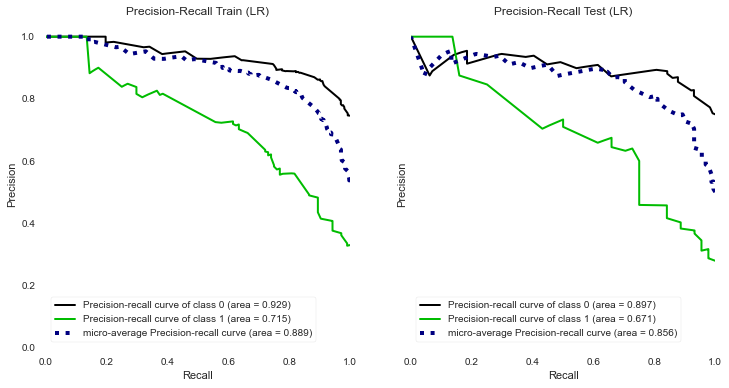

In [252]:
fig_pr, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
skplt.metrics.plot_precision_recall(y_train, lr_prob_train, ax=ax[0], title="Precision-Recall Train (LR)")
skplt.metrics.plot_precision_recall(y_test, lr_prob_test, ax=ax[1], title="Precision-Recall Test (LR)")
plt.show()

The above graphs show that the Precision-Recall curves for both the training and test data for the LR model. Looking at the area scores we can can see that the class 0 is able to acheive a high precision and recall score as the threshold changes. This means the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

The same is not true for the high salary class. As it's recall score increases so does the number of false positives, so it's accuracy decreases.

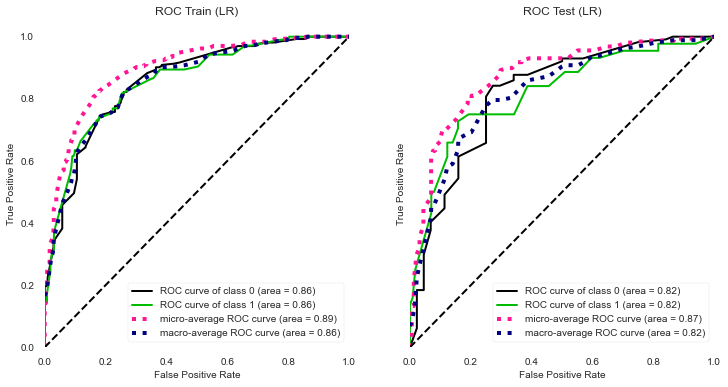

In [253]:
fig_pr, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
skplt.metrics.plot_roc(y_train, lr_prob_train, ax=ax[0], title='ROC Train (LR)')
skplt.metrics.plot_roc(y_test, lr_prob_test, ax=ax[1], title='ROC Test (LR)')
plt.show()

The ROC curves above show the the model is quite good at discriminating between the different classes. This can be see by the area scores . The AUC score matches the accuracy score (precision) for the positive class (class 0). The reason that the area scores are not 1 is due to some overlap between the different classes.

In relation to the question, in order to predict all low salary jobs correctly, we would need to select a point on the graphs that had a true positive rate of 1. The best point would also be the point that had the lowest False Positive rate. Looking at the graphs in this context,  a score of 1 for the TPR could be acheived if the FPR was between 0.7 and 0.9. So we are going to have a fair amount of fale positives!

As mentioned initially, we know need to moddify the LR model predictions so that the chance of predicting a low salary job as a high salary jobs is eliminated. The metric we will use to assess this is the recall score for low salary (class 0).

In [254]:
# Get the predicted probabilities for low and high salaries
Y_pp = pd.DataFrame(lr_model.predict_proba(X_train), 
             columns=['class_0_pp', 'class_1_pp'])
Y_pp.head()

,class_0_pp,class_1_pp
0,0.925573,0.074427
1,0.535512,0.464488
2,0.233092,0.766908
3,0.925573,0.074427
4,0.753912,0.246088


In [257]:
# create a function to alter predictions based on a given threshold
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

In [380]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [275]:
Y_pp.set_index(y_train.index) # set pp index to match y_train index

,class_0_pp,class_1_pp
253,0.925573,0.074427
149,0.535512,0.464488
55,0.233092,0.766908
250,0.925573,0.074427
148,0.753912,0.246088
...,...,...
104,0.753912,0.246088
508,0.874807,0.125193
180,0.561762,0.438238
324,0.724491,0.275509


In [381]:
# recall scores for class 0 - the low salary class
recalls_0 = np.array(
    [(i, recall_score(y_train, Y_pp.class_1_pp.apply(predict_at_threshold, threshold=i), pos_label=0)) 
        for i in np.linspace(0, 1, 1000)])


# recall scores for class 1
recalls_1 = np.array(
    [(i, recall_score(y_train, Y_pp.class_1_pp.apply(predict_at_threshold, threshold=i), pos_label=1)) 
        for i in np.linspace(0, 1, 1000)])

# precision scores for class 0 - the low salary class
precision_0 = np.array(
    [(i, precision_score(y_train, Y_pp.class_1_pp.apply(predict_at_threshold, threshold=i), pos_label=0)) 
        for i in np.linspace(0, 1, 1000)])


# recall scores for class 1
precision_1 = np.array(
    [(i, precision_score(y_train, Y_pp.class_1_pp.apply(predict_at_threshold, threshold=i), pos_label=1)) 
        for i in np.linspace(0, 1, 1000)])


# accuracy score for the LR model
accuracies = np.array(
    [(i, accuracy_score(y_train, Y_pp.class_1_pp.apply(predict_at_threshold, threshold=i))) 
        for i in np.linspace(0, 1, 1000)])

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


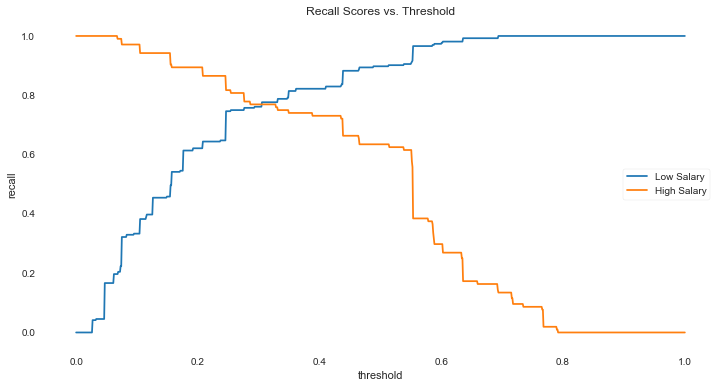

In [297]:
plt.figure(figsize=(12, 6))
plt.plot(recalls_0[:, 0], recalls_0[:, 1], label='Low Salary')
plt.plot(recalls_1[:, 0], recalls_1[:, 1], label='High Salary')
plt.xlabel('threshold')
plt.ylabel('recall')
plt.legend()
plt.title('Recall Scores vs. Threshold')
plt.show()

The above graph shows how the recall scores vary as the threshold increases. We can see the high salary score drops off reasonablly quickly, which means more true high salary jobs are being predicted as low salary as the threshold increases. This makes sense as the threshold is raising the probabiltiy at which jobs can be classified as high salary.

We can see that as we increase the threshold the recall for low salary jobs increases. It looks as though the recall score reaches 1 between 0.6 and 0.8, we can find out exacrly by looking at the results. Knowing this is exactly what we need in order to alter our model predictions in the way our boss wants!

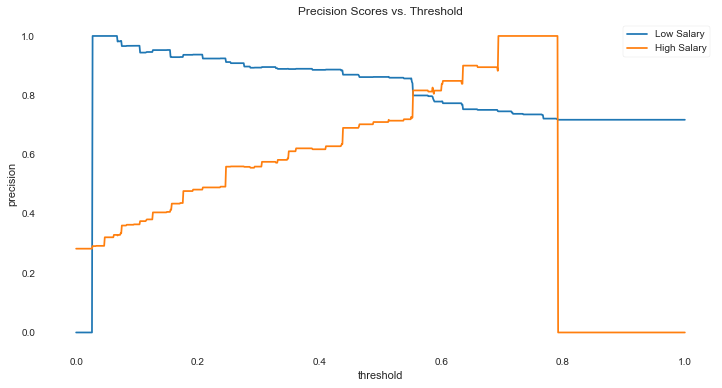

In [382]:
plt.figure(figsize=(12, 6))
plt.plot(precision_0[:, 0], precision_0[:, 1], label='Low Salary')
plt.plot(precision_1[:, 0], precision_1[:, 1], label='High Salary')
plt.xlabel('threshold')
plt.ylabel('precision')
plt.legend()
plt.title('Precision Scores vs. Threshold')
plt.show()

The above graphs shows how increasing the threshold impacts the precision scores for both classes. We can see that when the threshold is low class 0 (low salary) has perfect precision bfore gradually tailing off as the threshold increases. This makes sense as a low threshold means we are classifying more jobs are high salary jobs correctly (and hence reducing the false positives for the low salary class).

We can see the the precision score for the high salary class increases as the threshold increases. This makes sense as increasing the threshold will cause more jobs to be classified as low salary, and hence reduce the number of low salary jos mis-classified as high salary.

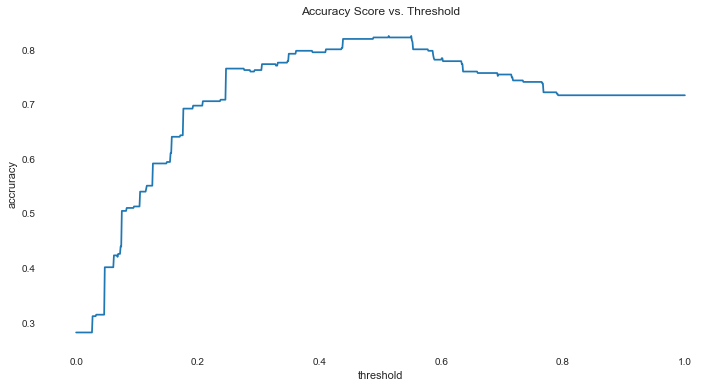

In [298]:
plt.figure(figsize=(12, 6))
plt.plot(accuracies[:, 0], accuracies[:, 1])
plt.xlabel('threshold')
plt.ylabel('accruracy')
plt.title('Accuracy Score vs. Threshold')
plt.show()

Looking at the above graph we can see the the accuracy of the LR model increases upto about 0.5 before it starts to decline. In order to keep the accuracy score as high as possible we should pick the low value for the threshold as possible (which still delivers on our boss' requirement).

In [324]:
thrsh = pd.DataFrame(recalls_0, columns=['threshold', 'recall_0_score'])

thrsh[thrsh.recall_0_score == 1.0][:10]

,threshold,recall_0_score
693,0.693694,1.0
694,0.694695,1.0
695,0.695696,1.0
696,0.696697,1.0
697,0.697698,1.0
698,0.698699,1.0
699,0.699700,1.0
700,0.700701,1.0
701,0.701702,1.0
702,0.702703,1.0


The `thrsh` data frame shows us the exact point where the recall score for low salaries became 1.0. The lowest threshold value was 0.693694, and so we should use this value to make our predictions.

In [375]:
# create predictions based on optimal threshold
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.693694)
Y_pp.head(10)

,class_0_pp,class_1_pp,pred_class_thresh
0,0.925573,0.074427,0
1,0.535512,0.464488,0
2,0.233092,0.766908,1
3,0.925573,0.074427,0
4,0.753912,0.246088,0
5,0.753912,0.246088,0
6,0.824450,0.175550,0
7,0.843354,0.156646,0
8,0.925573,0.074427,0
9,0.953319,0.046681,0


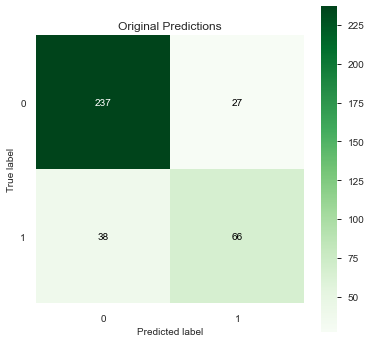

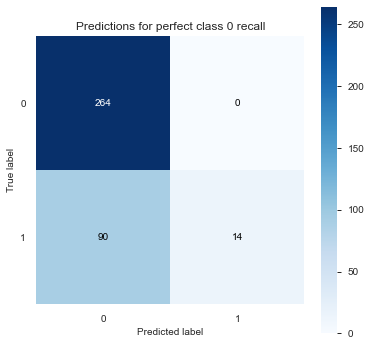

In [378]:
skplt.metrics.plot_confusion_matrix(y_train, lr_pred_train, labels=lr_model.classes_, 
                                    figsize=(6, 6), cmap='Greens', title='Original Predictions')
skplt.metrics.plot_confusion_matrix(y_train, Y_pp['pred_class_thresh'], 
                                    labels=lr_model.classes_, figsize=(6, 6), 
                                    title='Predictions for perfect class 0 recall')

plt.show()

The above confusion matrices show how the predictions have changed from the original predictions to those with the new threshold value. We can see that all class 0 (low salary) jobs were predicted. However, this perfect score came at the price of more high salary jobs be classified as low salary. We only classified jobs as high salary if the predicted probaility of a job being high salary was above our threshold of 0.693694.

In [379]:
# original classification scores
print(classification_report(y_train, lr_pred_train, labels=lr_model.classes_))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       264
           1       0.71      0.63      0.67       104

    accuracy                           0.82       368
   macro avg       0.79      0.77      0.77       368
weighted avg       0.82      0.82      0.82       368



In [327]:
# classification scores based on predictions using new threshold
print(classification_report(y_train, Y_pp['pred_class_thresh'], labels=lr_model.classes_))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85       264
           1       1.00      0.13      0.24       104

    accuracy                           0.76       368
   macro avg       0.87      0.57      0.55       368
weighted avg       0.82      0.76      0.68       368



The above classification reports echo what we saw in the confusion matrices (and reflects what we expected based on the ROC curves). Speficially, we have acheived a perfect recall score for class 0 (and as a result a perfect precision score for class 1!) but at the expense of the recall score for class 1. The accuracy score also dropped from 0.82 to 0.76, which we anticipated in the accuracy graph previously. 